In [1]:
import gurobipy as gb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 20; n = 4
T = list(range(1,T+1)); G = list(range(n))

################ Adulyasak et al. 2014
# C = floor(2*sum(d)/len(T))
################ Archetti et al. 2011
# h0 = 8; f = 100*10*8; d = U[5, 25]

h = 8; f = 2*15*h
I0 = {g:10 for g in G[:-1]}; d = {t:np.random.randint(5,25) for t in T}; C = np.floor(2*sum(list(d.values()))/len(T))
a = [0.75, 0.8, 0.9, 0.95]; alpha = dict(zip(G,a))


# Results functions

In [3]:
def print_summary(m, T, G, f, h, d, y, x, z, l, w, I, ntabs = 0):

    print("\t"*ntabs+f"Objective: {round(m.getObjective().getValue(),2)}\tRuntime: {round(m.RunTime,5)}")
    print("\t"*ntabs+f"\tSetup cost: {round(sum(f*y[t].x for t in T),2)}")
    print("\t"*ntabs+f"\tHolding cost: {round(sum(h*I[t,g] for t in T for g in G),2)}\n")

    print("\t"*ntabs+" ", *[" "*(5-len(str(t)))+str(t) for t in T], "Total", sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))
    print("\t"*ntabs+"d", *[" "*(5-len(str(d[t])))+str(d[t]) for t in T], sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))
    print("\t"*ntabs+"x", *[" "*(5-len(str(int(x[t]))))+str(int(x[t])) if int(x[t]) > 0 else "    ." for t in T], " "*(5-len(str(int(sum(x[t] for t in T)))))+str(int(sum(x[t] for t in T))), sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))

    for g in G:
        print("\t"*ntabs+f"z{g}", *[" "*(5-len(str(int(z[t,g]))))+str(int(z[t,g])) if int(z[t,g]) > 0 else "    ." for t in T],  " "*(5-len(str(int(sum(z[t,g] for t in T)))))+str(int(sum(z[t,g] for t in T))), sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))
    
    print("\t"*ntabs+"l", *[" "*(5-len(str(int(l[t]))))+str(int(l[t])) if int(l[t]) > 0 else "    ." for t in T], " "*(5-len(str(int(sum(l[t] for t in T)))))+str(int(sum(l[t] for t in T))), sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))

    for g in G[:-1]:
        print("\t"*ntabs+f"I{g}", *[" "*(5-len(str(int(I[t,g]))))+str(int(I[t,g])) if int(I[t,g]) > 0 else "    ." for t in T],  " "*(5-len(str(int(sum(I[t,g] for t in T)))))+str(int(sum(I[t,g] for t in T))), sep="\t")
    print("\t"*ntabs+"-"*8*(3+len(T)))

    print("\t"*ntabs+"w", *[" "*(5-len(str(int(w[t]))))+str(int(w[t])) if int(w[t]) > 0 else "    ." for t in T], " "*(5-len(str(int(sum(w[t] for t in T)))))+str(int(sum(w[t] for t in T))), sep="\t")

def check_models_objectives(it, T, G, f, h, x, I, ntabs = 0, s = "Transportation"):

    objs = [round(f*sum(1 for t in T if round(x[m][t],2) > 0) + h*sum(I[m][t,g] for t in T for g in G),2) for m in [0,1]]; resp = True
    if objs[0] != objs[1]: print("\t"*ntabs+f"{it} DIFFERENT OBJECTIVE VALUES - Standard: {objs[0]}, {s}: {objs[1]}"); resp = False

    return resp


# Models functions

In [4]:
def standard_model(T, G, n, h, f, C, I0, d, alpha, beta = 0, epsilon = 1, output = False, verbose = False, FIFO = True):

    m = gb.Model("Standard Model")
    Tt = {t:[m for m in range(t,np.min((T[-1],t+n-1)) + 1)] for t in T}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Produced quantity in period t \in T
    x = {t:m.addVar(name=f"x_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}
    # Amount of product of age g \in G that is used to fulfill demand in period t \in T
    z = {(t,g):m.addVar(name=f"z_{t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G}
    # Lost sales of period t \in T
    l = {t:m.addVar(name=f"l_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}
    # Available inventory of product of age g \in G at the end of period t \in T
    I = {(t,g):m.addVar(name=f"I_{t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G}
    I.update({(0,g):I0[g] for g in I0})

    ######################################
    # CONSTRAINTS
    ######################################

    for t in T:
        # Inventory of fresh produce
        m.addConstr(I[t,0] == x[t] - z[t,0])

        for g in G[1:]: 
            # Inventory dynamics throughout the day   
            m.addConstr(I[t,g] == I[t-1,g-1] - z[t,g])
        
        # Production capacity
        m.addConstr(x[t] <= np.min((C,sum(d[m] for m in Tt[t])))*y[t])

        # Demand fulfillment and lost sales modeling
        m.addConstr(gb.quicksum(z[t,g] for g in G) + l[t] == d[t])

        # Individual demand service level constraint
        m.addConstr(gb.quicksum(z[t,k] for k in G)/d[t] >= beta)

    for g in G:
        # Total age service level constraint
        m.addConstr(gb.quicksum(z[t,k] for t in T for k in range(g+1)) >= alpha[g]*sum(d[t] for t in T))
    
    # Total waste control constraint
    m.addConstr(gb.quicksum(I[t,n-1] for t in T) <= epsilon*gb.quicksum(x[t] for t in T))

    if FIFO:
        gamma = {(t,g):m.addVar(name=f"gamma_{t,g}", vtype=gb.GRB.BINARY) for t in T for g in G}

        for t in T:

            for g in G:
                m.addConstr(I[t,g] <= C*(1-gamma[t,g]))

                if g < G[-1]:
                    m.addConstr(gamma[t,g] <= gamma[t,g+1])
                    m.addConstr(z[t,g] <= C*gamma[t,g+1])

    
    ######################################
    # OBJECTIVE FUNCTION
    ######################################
            
    m.setObjective(gb.quicksum(f*y[t] + h*gb.quicksum(I[t,g] for g in G) for t in T))

    m.update()
    m.setParam("OutputFlag",output)
    m.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    x = {t:x[t].x for t in T}
    z = {(t,g):z[t,g].x for t in T for g in G}
    l = {t:l[t].x for t in T}
    w = {t:I[t,n-1].x for t in T}
    I = {(t,g):I[t,g].x for t in T for g in G}

    if verbose: print_summary(m, T, G, f, h, d, y, x, z, l, w, I)

    return x, z, l, w, I
    
def transportation_model(T, G, n, h, f, C, I0, d, alpha, beta = 0, epsilon = 1, feasibility = False, output = False, verbose = False):

    mm = gb.Model("Standard Model")
    Tt = {t:[m for m in range(t,np.min((T[-1],t+n-1)) + 1)] for t in T}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in time period t \in T or not
    y = {t:mm.addVar(name=f"y_{t}",vtype=gb.GRB.BINARY) for t in T}
    # Production quantity of time period t \in \T
    x = {(t,m):mm.addVar(name=f"x_{t,m}",vtype=gb.GRB.CONTINUOUS) for t in T for m in Tt[t]}
    # Amount of initial inventory of age g \in G - {n-1} used to fulfill demand in time period t \in {1, ..., n-g-1}
    r = {(t,g):mm.addVar(name=f"r_{t,g}",vtype=gb.GRB.CONTINUOUS) for g in G[:-1] for t in range(1,n-g)}
    # Available inventory of age g \in \G at the end of time period t \in T
    I = {(t,g):mm.addVar(name=f"I_{t,g}",vtype=gb.GRB.CONTINUOUS) for t in T for g in G}
    # Lost sales of time period t \in T
    l = {t:mm.addVar(name=f"l_{t}",vtype=gb.GRB.CONTINUOUS) for t in T}
    # Generated waste in time period t \in T
    w = {t:mm.addVar(name=f"w_{t}",vtype=gb.GRB.CONTINUOUS) for t in T}

    ######################################
    # CONSTRAINTS
    ######################################      
    
    for g in G[:-1]:
        # Initial inventory modeling
        mm.addConstr(I0[g] == gb.quicksum(r[t,g] for t in range(1, n-g-1 + 1)) + w[n-g-1])
    
    for t in T:
        for g in G[:-1]:
            # Inventory of time periods and ages for which initial inventory can be used
            if t-g <= 0:
                mm.addConstr(I[t,g] == gb.quicksum(r[j,g-t] for j in range(t+1, (n-1) - (g-t) + 1)) + w[(n-1)-(g-t)])
            # Inventory of time periods and ages for which waste is realized within the planning horizon
            elif 1 <= t-g and t-g <= T[-1]-n+1:
                mm.addConstr(I[t,g] == gb.quicksum(x[t-g, m] for m in Tt[t-g] if m>t) + w[(n-1) + (t-g)])
            # Inventory for time periods and ages for which waste is NOT realized within the planning horizon
            elif t-g >= T[-1]-n+2 and t < T[-1]:
                mm.addConstr(I[t,g] == gb.quicksum(x[t-g, m] for m in Tt[t-g] if m>t))
        # Inventory of oldest product
        mm.addConstr(I[t, n-1] == w[t])

        # Demand modeling
        if t <= n-1:
            mm.addConstr(gb.quicksum(r[t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[j,t] for j in range(1, t+1)) + l[t] == d[t])
        else:
            mm.addConstr(gb.quicksum(x[j,t] for j in range(t-n+1, t+1)) + l[t] == d[t])
        
        # Production capacity constraints
        if t+n-1 <= T[-1]:
            mm.addConstr(gb.quicksum(x[t,m] for m in Tt[t]) + w[t+n-1] <= C*y[t])
        else:
            mm.addConstr(gb.quicksum(x[t,m] for m in Tt[t]) <= C*y[t])
        for m in Tt[t]:
            mm.addConstr(x[t,m] <= np.min((C,d[m]))*y[t])

    # Age service level constraints
    mm.addConstr(gb.quicksum(x[t,t] for t in T) >= alpha[0]*sum(d[t] for t in T))
    for g in G[1:]:
        mm.addConstr(gb.quicksum(x[t,m] for t in T for m in Tt[t] if m-t<=g) + gb.quicksum(r[t,k] for t in range(1, g+1) for k in range(g-t+1)) >= alpha[g]*sum(d[t] for t in T))
    
    # Demand service level per time period
    for t in T:
        if t <= n-1:
            mm.addConstr(gb.quicksum(r[t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[j,t] for j in range(1, t+1)) >= beta*d[t])
        else:
            mm.addConstr(gb.quicksum(x[j,t] for j in range(t-n+1, t+1)) >= beta*d[t])

    # Waste control constraint
    mm.addConstr(gb.quicksum(w[t] for t in T) <= epsilon*(gb.quicksum(x[t,m] for t in T for m in Tt[t])+gb.quicksum(w[t] for t in T if t >= n)))
    
    ######################################
    # OBJECTIVE FUNCTION
    ######################################
            
    mm.setObjective(gb.quicksum(f*y[t] + h*gb.quicksum(I[t,g] for g in G) for t in T))

    mm.update()
    mm.setParam("OutputFlag",output)
    mm.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    xx = {t:sum(x[t,m].x for m in Tt[t])+w[t+n-1].x if t+n-1 <= T[-1] else sum(x[t,m].x for m in Tt[t]) for t in T}
    z = {(t,g):x[t-g,t].x if t-g >= 1 else r[t,g-t].x for t in T for g in G}
    l = {t:l[t].x for t in T}
    w = {t:w[t].x for t in T}
    I = {(t,g):I[t,g].x for t in T for g in G}

    ######################################
    # FEASIBILITY CHECK
    ######################################
    if feasibility:
        for t in T:
            if round(xx[t],3) > C*y[t].x: print(f"\t\tProduction capacity constraint for day {t} is violated. {xx[t]} > {C*y[t].x}")
            dem = round(sum(z[t,g] for g in G) + l[t],3)
            if dem != round(d[t],3): print(f"\t\tDemand modeling of period {t} doesn't add up. {dem} != {d[t]}")
        
        for g in G:
            sl = round(sum(z[t,k] for t in T for k in range(0, g+1))/sum(d[t] for t in T),3)
            if sl < alpha[g]: print(f"\t\tTotal age service level constraint for age {g} is violated. {sl} < {alpha[g]}")
        
        waste = sum(I[t, n-1] for t in T)/sum(xx[t] for t in T)
        if waste > epsilon: print(f"\t\tTotal waste level constraint is violated. {waste} > {epsilon}")

    if verbose: print_summary(mm, T, G, f, h, d, y, xx, l, w, I)

    return xx, z, l, w, I

# Formulations equivalence check

In [5]:
# [5,10,15,20,25], [1,2,3,4,5,10]

for tt in [10,20,30]:
    for n in [5,10]:
        
        if tt >= n and n <= tt/2:
            
            T = list(range(1,tt+1)); G = list(range(n))
            I0 = {g:10 for g in G[:-1]}
            print(f"Checking for |T| = {tt}, n = {n}")

            for a0 in [0, 0.2, 0.4, 0.6]:
                for a1 in [0.8, 0.9, 1]:

                    a = [round(a0+(a1-a0)*i/(n-1),3) if len(G)>1 else 0.7 for i in range(len(G))]
                    alpha = dict(zip(G,a))

                    print(f"\talpha_0 = {a0}, alpha_n1 = {a1}")

                    correct = 0
                    while correct <= 1000:
                        
                        #try:
                        d = {t:np.random.rand()*20+5 for t in T}
                        C = np.floor(2*sum(list(d.values()))/len(T))

                        x1, z1, l1, w1, I1 = standard_model(T, G, n, h, f, C, I0, d, alpha, FIFO = False)
                        x2, z2, l2, w2, I2 = transportation_model(T, G, n, h, f, C, I0, d, alpha)
                        resp = check_models_objectives(correct, T, G, f, h, (x1,x2), (I1,I2), ntabs=2)

                        if not resp: x2, z2, l2, w2, I2 = transportation_model(T, G, n, h, f, C, I0, d, alpha, feasibility = True)

                        correct += 1
                        if correct % 200 == 0: print(f"\t\t --- DONE {correct}")

                        #except:
                        #    continue

Checking for |T| = 10, n = 5
	alpha_0 = 0, alpha_n1 = 0.8
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-14
		 --- DONE 200
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		 --- DONE 1000
	alpha_0 = 0, alpha_n1 = 0.9
		 --- DONE 200
		205 DIFFERENT OBJECTIVE VALUES - Standard: 1523.09, Transportation: 1523.2
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		 --- DONE 1000
	alpha_0 = 0, alpha_n1 = 1
		 --- DONE 200
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		927 DIFFERENT OBJECTIVE VALUES - Standard: 1744.92, Transportation: 1745.0
		 --- DONE 1000
	alpha_0 = 0.2, alpha_n1 = 0.8
		 --- DONE 200
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		 --- DONE 1000
	alpha_0 = 0.2, alpha_n1 = 0.9
		 --- DONE 200
		376 DIFFERENT OBJECTIVE VALUES - Standard: 1634.08, Transportation: 1634.15
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		 --- DONE 1000
	alpha_0 = 0.2, alpha_n1 = 1
		 --- DONE 200
		 --- DONE 400
		 --- DONE 600
		 --- DONE 800
		 

# Other

In [ ]:
verbose = False
I0 = {g:0 for g in G[:-1]}

age1, age2 = list(), list()

for sl in range(11):

    print(f"Checking for total service level of {sl/10:.0%}")
    alpha = {0:0, 1:0, 2:0, 3:sl/10}

    for aa in range(1000):

        d = {t:np.random.rand()*20+5 for t in T}

        x1, z1, l1, w1, I1 = standard_model(T, G, n, h, f, C, I0, d, alpha, FIFO = False, verbose= False)
        x2, z2, l2, w2, I2 = standard_model(T, G, n, h, f, C, I0, d, alpha, verbose = False)

        resp = check_models_objectives(aa, T, G, f, h, (x1, x2), (I1, I2), ntabs=1, s="FIFO")

    

In [13]:
alpha = {0:0, 1:0, 2:0, 3:1}; verbose = False
I0 = {g:0 for g in G[:-1]}

age1, age2 = list(), list()

for aa in range(10000):

    d = {t:np.random.rand()*20+5 for t in T}

    x1, z1, l1, w1, I1 = standard_model(T, G, n, h, f, C, I0, d, alpha, FIFO = False, verbose= False)
    x2, z2, l2, w2, I2 = standard_model(T, G, n, h, f, C, I0, d, alpha, verbose = False)

    age1.append(sum(I1[t,g]*(g+1) for g in G for t in T)/sum(I1[t,g] for g in G for t in T))
    age2.append(sum(I2[t,g]*(g+1) for g in G for t in T)/sum(I2[t,g] for g in G for t in T))

    if aa % 500 == 0: print(f"Done {aa}")

Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
Done 6500
Done 7000
Done 7500
Done 8000
Done 8500
Done 9000
Done 9500


TtestResult(statistic=10.673356910952146, pvalue=7.994038556083073e-27, df=19998.0)


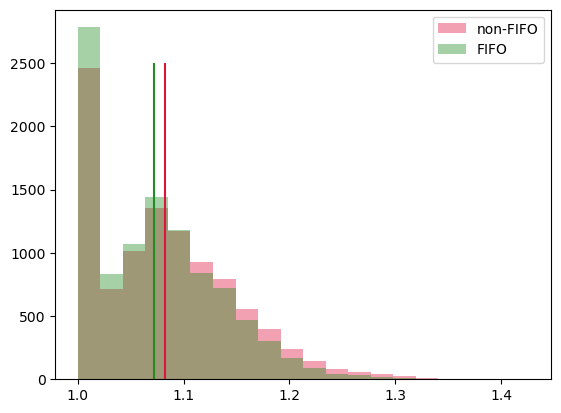

In [22]:
plt.hist(age1, bins=20, alpha=0.4, color="crimson", label="non-FIFO")
plt.hist(age2, bins=20, alpha=0.4, color="forestgreen", label="FIFO")
plt.vlines(x=np.average(age1), ymin=0, ymax=2500, color="crimson")
plt.vlines(x=np.average(age2), ymin=0, ymax=2500, color="forestgreen")
plt.legend()

from scipy.stats import ttest_ind

print(ttest_ind(age1, age2, alternative="greater"))